In [1]:
import tables
import pandas as pd
import numpy as np
import h5py
from tqdm.notebook import tqdm
from matplotlib import pyplot as plt
from scipy import stats
from iminuit import Minuit
import math
import scipy.optimize as optimize
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
import emcee
from scipy.constants import c
from scipy.special import erf
from scipy.stats import hypsecant
from scipy.stats import norm
from scipy.stats import laplace

from scipy.integrate import quad

from colossus.cosmology import cosmology
from colossus.lss import peaks
from colossus.halo import mass_so
from colossus.halo import concentration
from scipy import interpolate
from intergrid.intergrid import Intergrid
%load_ext cython

In [2]:
# new../
# old ./
for i in tqdm(range(50)):
    filename='../Downloads/UM_2d-20220418T173722Z-001/UM_2d/new_mock_2d_'+str(i)+'.npy'
    d = np.load(filename)
    df=pd.DataFrame.from_records(d.tolist(), columns=d.dtype.names)
    if i==0: df2=df
    else: df2=df2.append(df)

  0%|          | 0/50 [00:00<?, ?it/s]

In [3]:
df2=df2.reset_index(drop=True)
df2

,id,upid,x,y,z,vz,sm,sfr,icl,mp,...,hostr,rich_red_sp,mar,Vol,n,ainf,vravg,bin3d,bin,tag
0,10423006138,-1,4.031440,17.234131,91.366623,267.779999,1.265675e+12,1.576690,9.841825e+11,1.092859e+14,...,0.976222,31.0,0.287099,3.897041,1,0.3023,NaN,0,0,1
1,30000005231481032,10423006138,4.156453,16.853609,91.404953,-93.482491,7.514302e+10,0.072503,2.526506e+10,6.548751e+12,...,0.976222,31.0,0.287099,3.897041,1,0.0000,0.000000,6,6,0
2,32000004879831165,10423006138,3.719872,17.296618,91.075821,-586.436646,3.497926e+10,0.075920,5.277254e+08,1.145720e+12,...,0.976222,31.0,0.287099,3.897041,1,0.0000,0.000000,6,4,0
3,27000005764327304,10423006138,3.860375,17.180166,91.220757,-889.141663,6.465858e+10,0.107494,0.000000e+00,9.529140e+11,...,0.976222,31.0,0.287099,3.897041,1,0.0000,0.000000,3,2,0
4,16000007722938411,10423006138,3.409460,17.631683,91.215752,165.205124,5.195008e+10,0.110130,0.000000e+00,8.070051e+11,...,0.976222,31.0,0.287099,3.897041,1,0.0000,0.000000,11,11,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5135423,10560991948,10560991969,992.138794,938.410095,920.661682,672.460022,4.058310e+10,4.102032,2.483552e+09,4.131869e+11,...,0.823926,36.0,1.449028,2.342897,19,0.3023,188.889977,17,12,0
5135424,10560991881,10560991969,993.139038,937.326721,920.917542,464.279999,3.443873e+10,0.027448,5.711738e+08,7.876229e+11,...,0.823926,36.0,1.449028,2.342897,19,0.3023,608.097782,17,16,0
5135425,10560991965,10560991969,991.583252,938.003296,921.428833,532.679993,1.037432e+10,0.003338,7.785041e+08,3.407543e+11,...,0.823926,36.0,1.449028,2.342897,19,0.3023,506.714590,14,14,0
5135426,10560992045,10560991969,992.953857,937.915161,921.393127,338.950012,9.276681e+09,0.033343,3.186511e+09,7.508916e+11,...,0.823926,36.0,1.449028,2.342897,19,0.3023,139.517160,11,11,0


In [4]:
r_Mpc=df2.hostr*1e6 #Pc
G = 4.3009e-3 #M_solar^-1 pc (km/s)^2

In [5]:
df2['vcirc']=np.sqrt(G*df2.hostm/r_Mpc)

In [6]:
#params = {'flat': True, 'H0': 67, 'Om0': 0.31, 'Ob0': 0.049, 'sigma8': 0.81, 'ns': 0.95}
#cosmology.addCosmology('myCosmo', params)
#cosmo = cosmology.setCosmology('myCosmo')
cosmo = cosmology.setCosmology('planck13')

df2['nu']=peaks.peakHeight(df2.hostm,0)
df2['alpha']=0.155+0.0095*df2.nu**2

mass_grid=np.linspace(1,25,1000)

concentration.concentration(1e14, '200m', 0, model = 'ishiyama21')

c200m_grid=concentration.concentration(mass_grid*1e14, '200m', 0, model = 'ishiyama21')

conc = interpolate.interp1d(mass_grid,c200m_grid)

df2['c200m']=conc(df2.hostm/1e14)

df2['r_s']=df2.hostr/df2.c200m

In [7]:
%%cython

from cpython.pycapsule cimport (PyCapsule_New,
                                PyCapsule_GetPointer)
from cpython.mem cimport PyMem_Malloc,  PyMem_Free
from libc.math cimport exp, sqrt
import scipy

cdef double c_integrand(double x, void* user_data):
    """The integrand, written in Cython"""
    # Extract a.
    # Cython uses array access syntax for pointer dereferencing!    
    cdef double R = (<double*>user_data)[0]
    cdef double alpha = (<double*>user_data)[1]
    cdef double r_s = (<double*>user_data)[2]
    cdef double r_t = (<double*>user_data)[3]
    
    r=x
    
    beta=4
    gamma=6
    arg=-2/alpha*((r/r_s)**alpha-1)
    coeff=(1+(r/r_t)**beta)**(-gamma/beta)
    rho_3d=exp(arg)*coeff
    
    return rho_3d*r/sqrt(r**2-R**2)

#
# Now comes some classic C-style housekeeping
#

cdef object pack_a(double R, double alpha, double r_s, double r_t):
    """Wrap 'a' in a PyCapsule for transport."""
    # Allocate memory where 'a' will be saved for the time being
    cdef double* a_ptr = <double*> PyMem_Malloc(4*sizeof(double))
    a_ptr[0] = R
    a_ptr[1] = alpha
    a_ptr[2] = r_s
    a_ptr[3] = r_t
    return PyCapsule_New(<void*>a_ptr, NULL, free_a)

cdef void free_a(capsule):
    """Free the memory our value is using up."""
    PyMem_Free(PyCapsule_GetPointer(capsule, NULL))

def get_low_level_callable(double R, double alpha, double r_s, double r_t):
    # scipy.LowLevelCallable expects the function signature to
    # appear as the "name" of the capsule
    func_capsule = PyCapsule_New(<void*>c_integrand,
                                 "double (double, void *)",
                                 NULL)
    data_capsule = pack_a(R,alpha,r_s,r_t)
    
    return scipy.LowLevelCallable(func_capsule, data_capsule)

In [8]:
@np.vectorize
def proj2d_c(alpha,r_s,r_t,R):
    c_integrand = get_low_level_callable(R,alpha,r_s,r_t)
    y, abserr = quad(c_integrand, R, np.inf)
    return 2*y

In [9]:
import pickle
pkl_file = open('../ACTmodel/Surfaceintegral.pkl', 'rb')

V = pickle.load(pkl_file)

lo = np.array([ 0.1, .05, .1, 0 ])  # lowest lat, lowest lon
hi = np.array([ .6, .5, 7, 6 ])   # highest lat, highest lon

Surface = Intergrid( V, lo=lo, hi=hi, verbose=0 )

In [10]:
df2['justr']=df2.d2d*df2.hostr

df2['r_lambda']=(df2.rich_red_sp / 100.0) ** 0.2

#df2['r_edge']=2.2*df2.r_lambda
df2['r_edge']=2.0*df2.hostr

In [11]:
orbit=df2[df2.tag==0]

In [12]:
np.max(orbit.justr/orbit.r_edge)

1.9986616373062134

In [13]:
N=50

Text(0, 0.5, '$\\Sigma$')

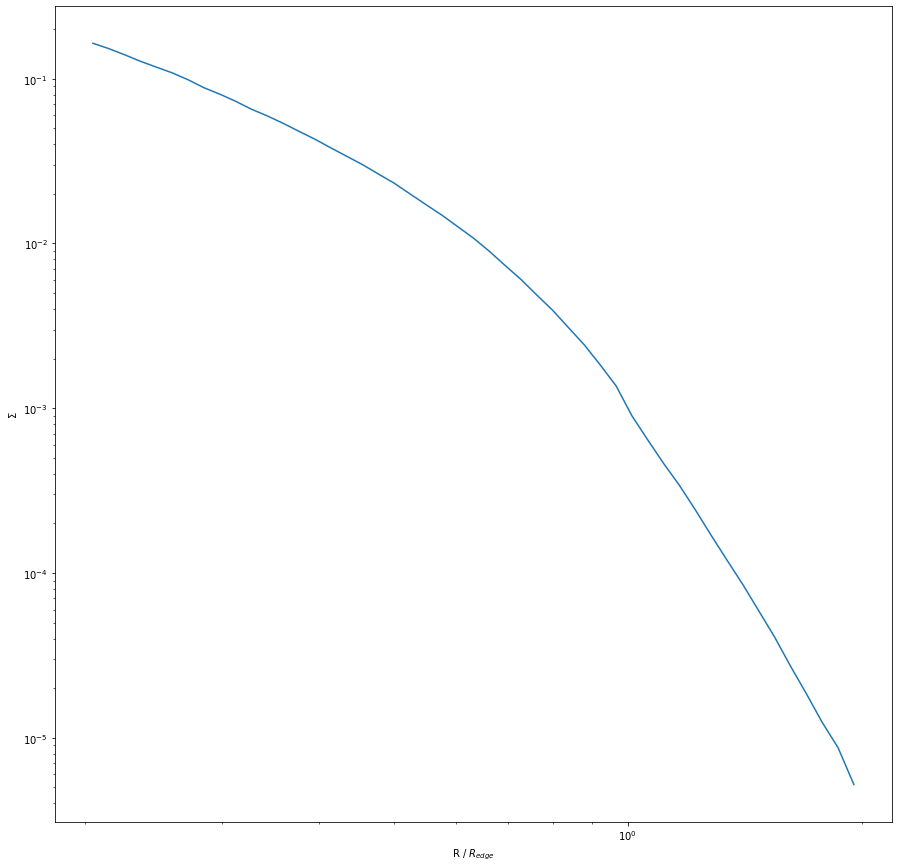

In [14]:
k_t=1
points=list(zip(orbit.alpha,orbit.r_s,orbit.r_edge/k_t,orbit.d2d*orbit.hostr))
sol=Surface.at(points)

#ax1.scatter(df_full.r,sol)
intervals=np.logspace(np.log10(.2),np.log10(2),N)
center=(intervals[:-1]+intervals[1:])/2

x=orbit.d2d*orbit.hostr/orbit.r_edge
y=sol*orbit.r_edge

n, _ = np.histogram(x, bins=intervals)
sy, _ = np.histogram(x, bins=intervals, weights=y)
sy2, _ = np.histogram(x, bins=intervals, weights=y*y)
mean = sy / n
std = np.sqrt(sy2/n - mean*mean)

fig,ax1 = plt.subplots(1, 1,figsize=(15,15))
#ax1.plot(x, y, 'bo')
ax1.plot(center, mean)
#plt.errorbar((_[1:] + _[:-1])/2, mean, yerr=std, fmt='r-')

ax1.set_yscale('log')
ax1.set_xscale('log')
ax1.set_xlabel('R / $R_{edge}$')
ax1.set_ylabel('$\Sigma$')
#ax1.legend()

<ipython-input-15-685df4a7a613>:16: RuntimeWarning: invalid value encountered in sqrt
  std = np.sqrt(sy2/n - mean16*mean16)


Text(0, 0.5, '$\\Sigma$')

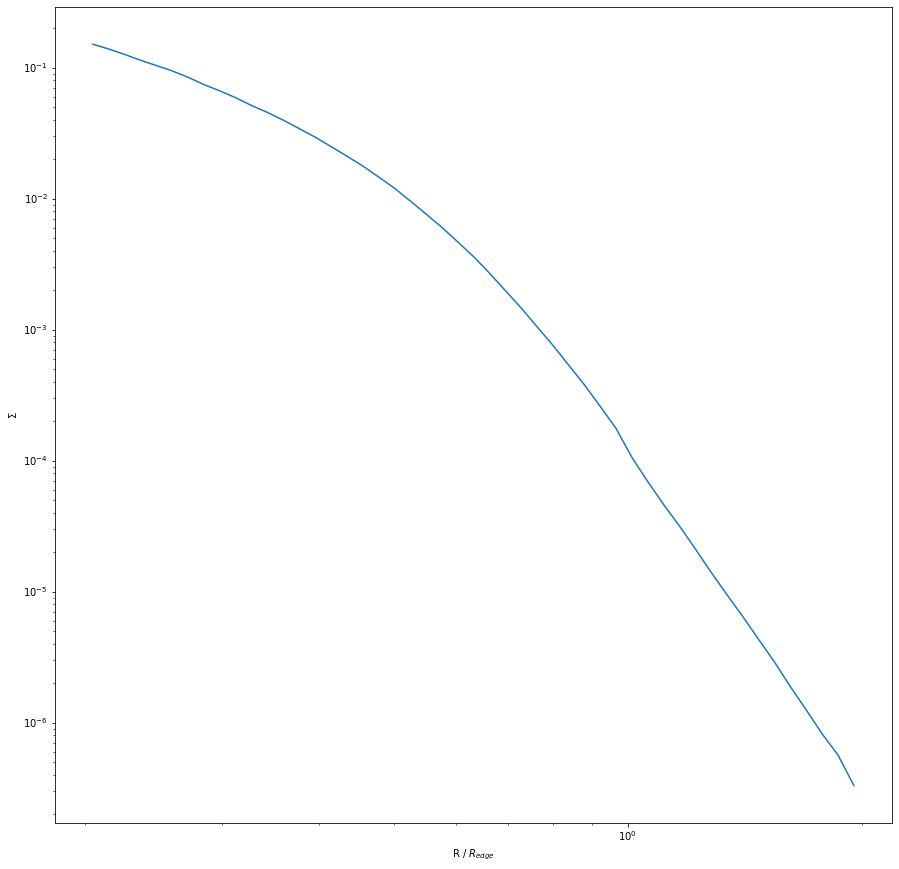

In [15]:
k_t=1.6
points=list(zip(orbit.alpha,orbit.r_s,orbit.r_edge/k_t,orbit.d2d*orbit.hostr))
sol=Surface.at(points)

#ax1.scatter(df_full.r,sol)
intervals=np.logspace(np.log10(.2),np.log10(2),N)
center=(intervals[:-1]+intervals[1:])/2

x=orbit.d2d*orbit.hostr/orbit.r_edge
y=sol*orbit.r_edge

n, _ = np.histogram(x, bins=intervals)
sy, _ = np.histogram(x, bins=intervals, weights=y)
sy2, _ = np.histogram(x, bins=intervals, weights=y*y)
mean16 = sy / n
std = np.sqrt(sy2/n - mean16*mean16)

fig,ax1 = plt.subplots(1, 1,figsize=(15,15))
#ax1.plot(x, y, 'bo')
ax1.plot(center, mean16)
#plt.errorbar((_[1:] + _[:-1])/2, mean, yerr=std, fmt='r-')

ax1.set_yscale('log')
ax1.set_xscale('log')
ax1.set_xlabel('R / $R_{edge}$')
ax1.set_ylabel('$\Sigma$')
#ax1.legend()

In [16]:
Sigma_orb=[]
Sigma_inf=[]
Sigma_bg=[]
Sigma_orb_e=[]
Sigma_inf_e=[]
Sigma_bg_e=[]

for plt_idx in tqdm(range(0,len(intervals)-1)):
    minr=intervals[plt_idx]
    maxr=intervals[plt_idx+1]
    
    area=np.pi*(maxr**2-minr**2)
    dfcut=df2[ (df2.justr/df2.r_edge>minr) & (df2.justr/df2.r_edge<=maxr) & (df2.tag==0)].copy()
    dfcut=dfcut.reset_index()
    
    count=len(dfcut)
    Sigma_orb=np.append(Sigma_orb,count/area)
    Sigma_orb_e=np.append(Sigma_orb_e,np.sqrt(count)/area)

    dfcut=df2[ (df2.justr/df2.r_edge>minr) & (df2.justr/df2.r_edge<=maxr) & (df2.tag==1)].copy()
    dfcut=dfcut.reset_index()
    
    count=len(dfcut)
    Sigma_inf=np.append(Sigma_inf,count/area)
    Sigma_inf_e=np.append(Sigma_inf_e,np.sqrt(count)/area)

    dfcut=df2[ (df2.justr/df2.r_edge>minr) & (df2.justr/df2.r_edge<=maxr) & (df2.tag==2)].copy()
    dfcut=dfcut.reset_index()
    
    count=len(dfcut)
    Sigma_bg=np.append(Sigma_bg,count/area)
    Sigma_bg_e=np.append(Sigma_bg_e,np.sqrt(count)/area)

  0%|          | 0/49 [00:00<?, ?it/s]

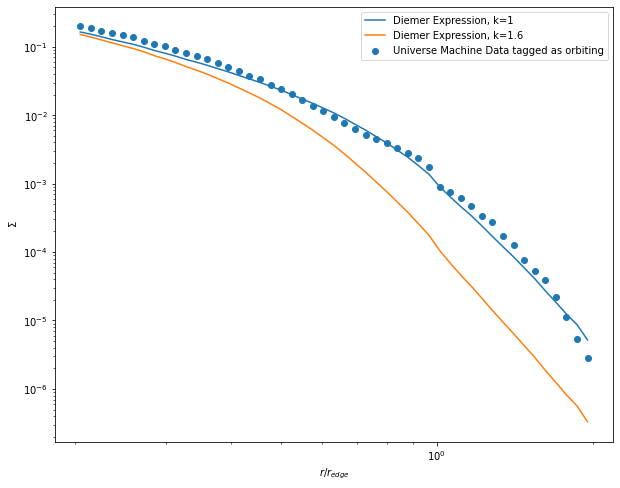

In [17]:
fig,(ax1) = plt.subplots(1, 1,figsize=(10,8))

ax1.scatter(center,Sigma_orb/3.4e6, label='Universe Machine Data tagged as orbiting')
ax1.plot((_[1:] + _[:-1])/2, mean, label='Diemer Expression, k=1')
ax1.plot((_[1:] + _[:-1])/2, mean16, label='Diemer Expression, k=1.6')


ax1.legend()
ax1.set_xlabel('$r/r_{edge}$')
ax1.set_ylabel('$\Sigma$')
#ax1.set_ylim([1e2,1e7])
ax1.set_xscale('log')
ax1.set_yscale('log')

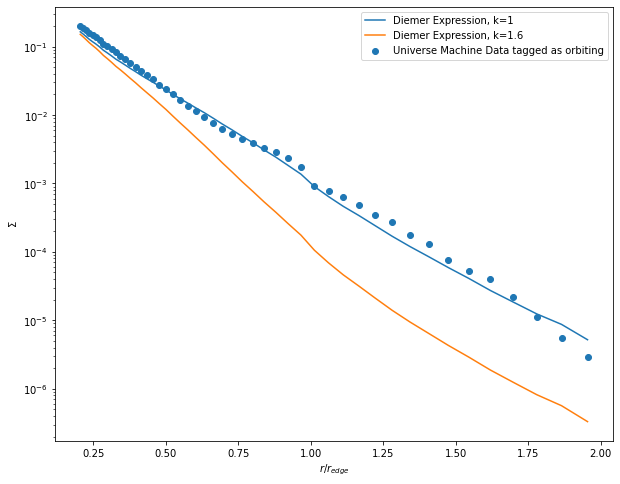

In [18]:
fig,(ax1) = plt.subplots(1, 1,figsize=(10,8))

ax1.scatter(center,Sigma_orb/3.4e6, label='Universe Machine Data tagged as orbiting')
ax1.plot((_[1:] + _[:-1])/2, mean, label='Diemer Expression, k=1')
ax1.plot((_[1:] + _[:-1])/2, mean16, label='Diemer Expression, k=1.6')


ax1.legend()
ax1.set_xlabel('$r/r_{edge}$')
ax1.set_ylabel('$\Sigma$')
#ax1.set_ylim([1e2,1e7])
#ax1.set_xscale('log')
ax1.set_yscale('log')

In [21]:
from scipy.stats import linregress

x = np.log(center)
y = np.log(Sigma_inf) 

infreg = linregress(x, y)

x = np.log(center)
y = np.log(Sigma_bg) 

bgreg = linregress(x, y)

In [22]:
intervals2=np.linspace(1.1,1.9,5)
rwidth = intervals2[1] - intervals2[0]
#intervals=np.logspace(np.log10(.2),np.log10(2),N)
center2=(intervals2[:-1]+intervals2[1:])/2

Sigma_orb2=[]
Sigma_inf2=[]
Sigma_bg2=[]
Sigma_orb_e2=[]
Sigma_inf_e2=[]
Sigma_bg_e2=[]

for plt_idx in tqdm(range(0,len(intervals2))):
    minr=intervals2[plt_idx]-rwidth
    maxr=intervals2[plt_idx]+rwidth
    
    area=np.pi*(maxr**2-minr**2)
    dfcut=df2[ (df2.justr/df2.r_edge>minr) & (df2.justr/df2.r_edge<=maxr) & (df2.tag==0)].copy()
    dfcut=dfcut.reset_index()
    
    count=len(dfcut)
    Sigma_orb2=np.append(Sigma_orb2,count/area)
    Sigma_orb_e2=np.append(Sigma_orb_e2,np.sqrt(count)/area)

    dfcut=df2[ (df2.justr/df2.r_edge>minr) & (df2.justr/df2.r_edge<=maxr) & (df2.tag==1)].copy()
    dfcut=dfcut.reset_index()
    
    count=len(dfcut)
    Sigma_inf2=np.append(Sigma_inf2,count/area)
    Sigma_inf_e2=np.append(Sigma_inf_e2,np.sqrt(count)/area)

    dfcut=df2[ (df2.justr/df2.r_edge>minr) & (df2.justr/df2.r_edge<=maxr) & (df2.tag==2)].copy()
    dfcut=dfcut.reset_index()
    
    count=len(dfcut)
    Sigma_bg2=np.append(Sigma_bg2,count/area)
    Sigma_bg_e2=np.append(Sigma_bg_e2,np.sqrt(count)/area)

  0%|          | 0/5 [00:00<?, ?it/s]

In [23]:
from scipy.stats import linregress

x = np.log(intervals2)
y = np.log(Sigma_inf2) 

infreg2 = linregress(x, y)

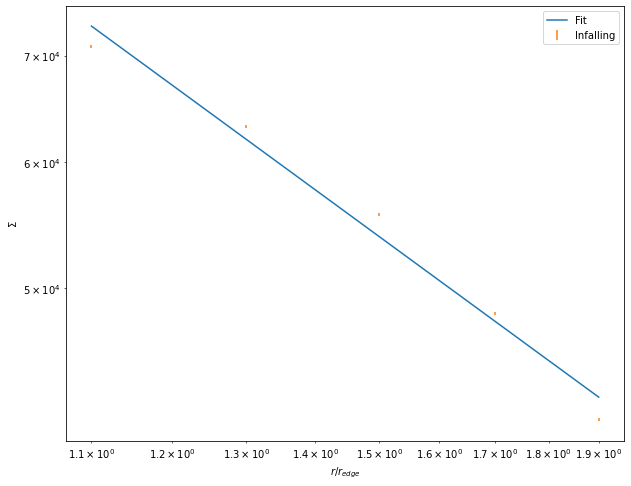

In [33]:
fig,(ax1) = plt.subplots(1, 1,figsize=(10,8))

ax1.plot(intervals2, np.exp(infreg2.intercept)*intervals2**infreg2.slope, label='Fit')
j=ax1.errorbar(intervals2,Sigma_inf2,Sigma_inf_e2,linestyle='None', label='Infalling')

ax1.legend()
ax1.set_xlabel('$r/r_{edge}$')
ax1.set_ylabel('$\Sigma$')
ax1.set_xscale('log')
ax1.set_yscale('log')

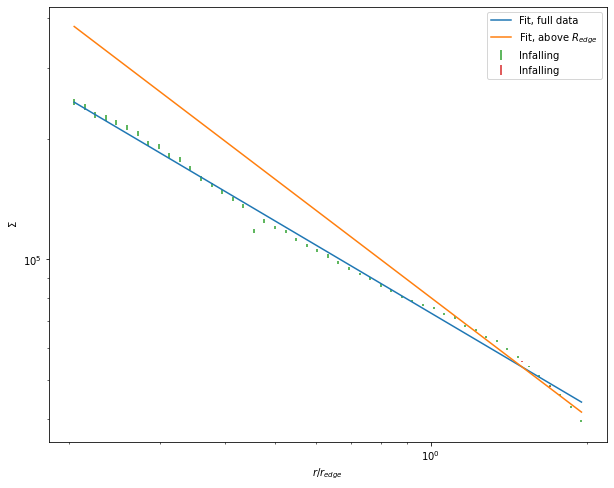

In [25]:
fig,(ax1) = plt.subplots(1, 1,figsize=(10,8))

#i=ax1.errorbar(center, sigma_inf, yerr=inf_error, fmt='o',markersize=4)
#i=ax1.scatter(center[:41],Sigma_orb[:41])
ax1.plot(center, np.exp(infreg.intercept)*center**infreg.slope, label='Fit, full data')
#ax1.plot(center, np.exp(infreg2.intercept)*center**infreg2.slope, label='Fit')
ax1.plot(center, np.exp(infreg2.intercept)*center**infreg2.slope, label='Fit, above $R_{edge}$')

#ax1.plot(center, np.exp(bgreg.intercept)*center**bgreg.slope)

j=ax1.errorbar(center,Sigma_inf,Sigma_inf_e,linestyle='None', label='Infalling')
#j=ax1.errorbar(center2,Sigma_inf2,Sigma_inf_e2,linestyle='None', label='Infalling')
k=ax1.errorbar(intervals2,Sigma_inf2,Sigma_inf_e2,linestyle='None', label='Infalling', markersize=10)

#k=ax1.scatter(center,Sigma_bg)
#m=ax1.scatter(center,Sigma_bg+Sigma_orb+Sigma_inf)
ax1.legend()
ax1.set_xlabel('$r/r_{edge}$')
ax1.set_ylabel('$\Sigma$')
#ax1.set_ylim([1e2,1e7])
ax1.set_xscale('log')
ax1.set_yscale('log')

In [26]:
infreg2.slope

-0.9825225837196365

In [27]:
np.exp(infreg2.intercept)

80215.46969663317

In [28]:
np.exp(infreg.intercept)

73401.37542051473

In [29]:
infreg.slope

-0.7641214286005513

In [94]:
Sigma=pd.DataFrame({'r':center,'sigma_orb':Sigma_orb,'sigma_inf':Sigma_inf,'sigma_bg':Sigma_bg})

In [95]:
import pickle

output = open('Sigma.pkl', 'wb')
pickle.dump(Sigma, output)
output.close()

In [31]:
intervals=np.linspace(0,5,N)
center=(intervals[:-1]+intervals[1:])/2

Sigma_orb=[]
Sigma_inf=[]
Sigma_bg=[]

for plt_idx in tqdm(range(0,len(intervals)-1)):
    minr=intervals[plt_idx]
    maxr=intervals[plt_idx+1]
    
    area=4/3*np.pi*(maxr**3-minr**3)
    dfcut=df2[ (df2.d3d>minr) & (df2.d3d<=maxr) & (df2.tag==0)].copy()
    dfcut=dfcut.reset_index()
    
    count=len(dfcut)
    Sigma_orb=np.append(Sigma_orb,count/area)
    
    dfcut=df2[ (df2.d3d>minr) & (df2.d3d<=maxr) & (df2.tag==1)].copy()
    dfcut=dfcut.reset_index()
    
    count=len(dfcut)
    Sigma_inf=np.append(Sigma_inf,count/area)
    
    dfcut=df2[ (df2.d3d>minr) & (df2.d3d<=maxr) & (df2.tag==2)].copy()
    dfcut=dfcut.reset_index()
    
    count=len(dfcut)
    Sigma_bg=np.append(Sigma_bg,count/area)

  0%|          | 0/49 [00:00<?, ?it/s]

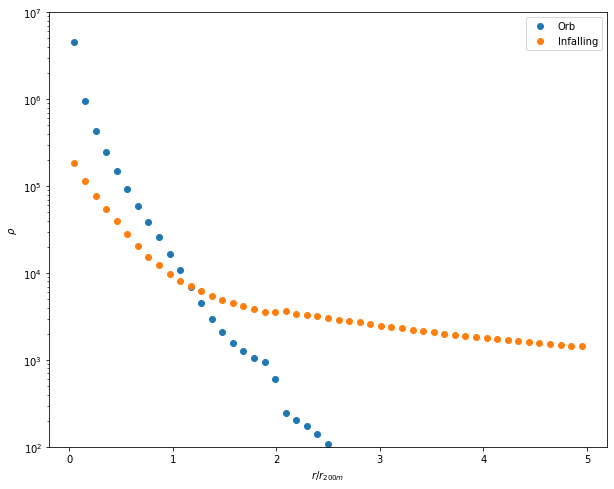

In [32]:
fig,(ax1) = plt.subplots(1, 1,figsize=(10,8))

#i=ax1.errorbar(center, sigma_inf, yerr=inf_error, fmt='o',markersize=4)
i=ax1.scatter(center[:40],Sigma_orb[:40])
j=ax1.scatter(center,Sigma_inf)
#k=ax1.scatter(center,Sigma_bg)
#m=ax1.scatter(center,Sigma_bg+Sigma_orb+Sigma_inf)
#ax1.legend((i,j,k,m),('Orb','Infalling','BG','All'))
ax1.legend((i,j),('Orb','Infalling'))
ax1.set_xlabel('$r/r_{200m}$')
ax1.set_ylabel('$\\rho$')
ax1.set_ylim([1e2,1e7])
ax1.set_yscale('log')